In [1]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)


#NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
api_key = '####'

In [3]:
channel_ids = ['UC7cs8q-gJRlGwj4A8OmCmXg',
              # more channels here
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalViews': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Alex The Analyst,300000,11825485,170,UU7cs8q-gJRlGwj4A8OmCmXg


In [8]:
playlist_id = "UU7cs8q-gJRlGwj4A8OmCmXg"

def get_video_ids(youtube, playlist_id):
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids


In [9]:
video_ids = get_video_ids(youtube, playlist_id)

In [10]:
len(video_ids)

171

In [11]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    return pd.DataFrame(all_video_info)

In [12]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,WUeBzT43JyY,Alex The Analyst,Installing Jupyter Notebooks/Anaconda | Python...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-18T11:00:30Z,581,78,None,15,PT10M3S,hd,false
1,sXHIIW3Wt84,Alex The Analyst,300k Livestream! | Giveaways for People in Cha...,Time to Celebrate!!\n\nNormally I do giveaways...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-14T16:41:30Z,0,18,None,0,P0D,sd,false
2,DVs9u15htXU,Alex The Analyst,Interviewing Tina Huang | Fellow YouTuber and ...,I had the honor of interviewing Tina Huang at ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-13T11:00:07Z,4748,188,None,19,PT22M6S,hd,false
3,zW3qJUeJLWc,Alex The Analyst,Interviewing Luke Barousse | Arch-Nemesis and ...,I had the honor of interviewing Luke Barousse ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-11T11:00:42Z,4249,215,None,27,PT24M26S,hd,false
4,m1AkWK_ODLM,Alex The Analyst,When Best Friends Work Together (ft. Luke Baro...,When you get your first project with your best...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-04T10:30:09Z,10354,508,None,74,PT5M35S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,4rfr6A3lO-Y,Alex The Analyst,Data Analyst Resume | Reviewing My Resume! | F...,Data Analyst Resume | Reviewing My Resume! | F...,"[Data Analyst, How to become a data analyst, D...",2020-01-30T14:07:55Z,54415,1379,None,63,PT7M33S,hd,false
167,OTq2NRy_AGs,Alex The Analyst,Working at a Big Company Vs Small Company | To...,Working at a Big Company Vs Small Company | To...,"[Data Analyst, How to become a Data Analyst, B...",2020-01-25T16:38:39Z,11230,326,None,19,PT5M50S,hd,false
168,ya28cb3zFGE,Alex The Analyst,Data Analyst Salary | 100k with No Experience,Data Analyst Salary | 100k with No Experience ...,"[Data Analyst Salary, Data analyst with no exp...",2020-01-23T03:16:09Z,51339,1857,None,211,PT5M3S,hd,false
169,Hsi2BG0SOiQ,Alex The Analyst,Truth About Big Companies | Told by a Fortune ...,Truth About Big Companies // There are a ton o...,"[Working at a big company, Big company data an...",2020-01-21T03:52:15Z,6365,247,None,17,PT5M45S,hd,false


In [13]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

In [14]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

Could not get comments for video sXHIIW3Wt84


,video_id,comments
0,WUeBzT43JyY,"[كنت انتظر هذا \nشكرا لك, Awesome. Thanks Alex..."
1,DVs9u15htXU,[ok now i want to learn more about lonely octo...
2,zW3qJUeJLWc,[It's been my dream since a junior data analys...
3,m1AkWK_ODLM,"[Did we just become mortal enemies!?!? 😳, This..."
4,Pfq-8pGzgg4,[I am interested in data analyst and business ...
...,...,...
165,4rfr6A3lO-Y,[Thanks for watching! What is the weirdest thi...
166,OTq2NRy_AGs,[Would you rather work at a BIG Company or a S...
167,ya28cb3zFGE,[3:23\n76k hourly? I'm in!\nBut nice vid keep ...
168,Hsi2BG0SOiQ,"[Bro, you are spitting straight facts in this ..."


### Data Pre-processing

In [15]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [16]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [17]:
# Convert count columns to numeric columns
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [18]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [19]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [20]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs
0,WUeBzT43JyY,Alex The Analyst,Installing Jupyter Notebooks/Anaconda | Python...,In this series we will be walking through ever...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-18 11:00:30+00:00,581,78,NaN,15,PT10M3S,hd,false,Tuesday,603.0
1,sXHIIW3Wt84,Alex The Analyst,300k Livestream! | Giveaways for People in Cha...,Time to Celebrate!!\n\nNormally I do giveaways...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-14 16:41:30+00:00,0,18,NaN,0,P0D,sd,false,Friday,0.0
2,DVs9u15htXU,Alex The Analyst,Interviewing Tina Huang | Fellow YouTuber and ...,I had the honor of interviewing Tina Huang at ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-13 11:00:07+00:00,4748,188,NaN,19,PT22M6S,hd,false,Thursday,1326.0
3,zW3qJUeJLWc,Alex The Analyst,Interviewing Luke Barousse | Arch-Nemesis and ...,I had the honor of interviewing Luke Barousse ...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-11 11:00:42+00:00,4249,215,NaN,27,PT24M26S,hd,false,Tuesday,1466.0
4,m1AkWK_ODLM,Alex The Analyst,When Best Friends Work Together (ft. Luke Baro...,When you get your first project with your best...,"[Data Analyst, Data Analyst job, Data Analyst ...",2022-10-04 10:30:09+00:00,10354,508,NaN,74,PT5M35S,hd,false,Tuesday,335.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,4rfr6A3lO-Y,Alex The Analyst,Data Analyst Resume | Reviewing My Resume! | F...,Data Analyst Resume | Reviewing My Resume! | F...,"[Data Analyst, How to become a data analyst, D...",2020-01-30 14:07:55+00:00,54415,1379,NaN,63,PT7M33S,hd,false,Thursday,453.0
167,OTq2NRy_AGs,Alex The Analyst,Working at a Big Company Vs Small Company | To...,Working at a Big Company Vs Small Company | To...,"[Data Analyst, How to become a Data Analyst, B...",2020-01-25 16:38:39+00:00,11230,326,NaN,19,PT5M50S,hd,false,Saturday,350.0
168,ya28cb3zFGE,Alex The Analyst,Data Analyst Salary | 100k with No Experience,Data Analyst Salary | 100k with No Experience ...,"[Data Analyst Salary, Data analyst with no exp...",2020-01-23 03:16:09+00:00,51339,1857,NaN,211,PT5M3S,hd,false,Thursday,303.0
169,Hsi2BG0SOiQ,Alex The Analyst,Truth About Big Companies | Told by a Fortune ...,Truth About Big Companies // There are a ton o...,"[Working at a big company, Big company data an...",2020-01-21 03:52:15+00:00,6365,247,NaN,17,PT5M45S,hd,false,Tuesday,345.0


### EDA

#### Best performing videos

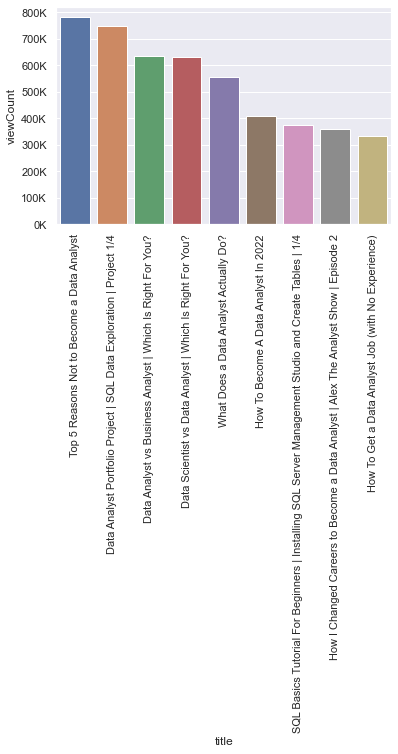

In [21]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values(
    'viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

#### Worst Performing Videos

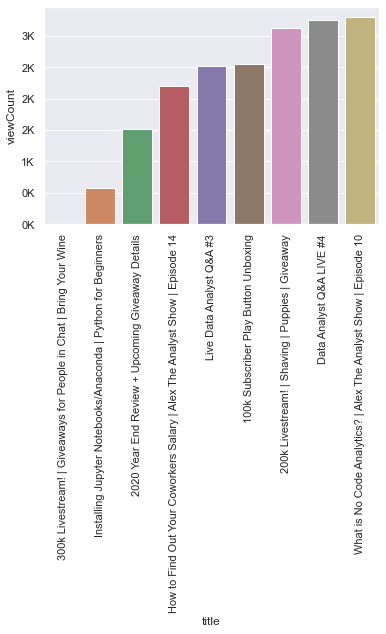

In [22]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values(
    'viewCount', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

#### View distribution per video

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


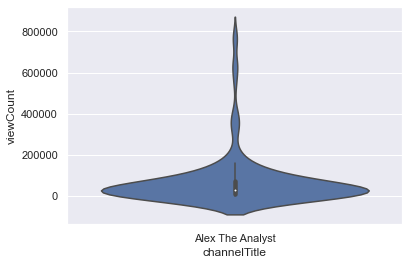

In [23]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])
plt.show()

#### Views vs. likes and comments

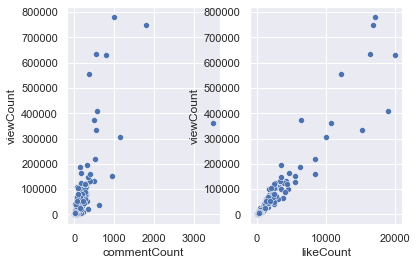

In [24]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])
plt.show()

#### Video duration

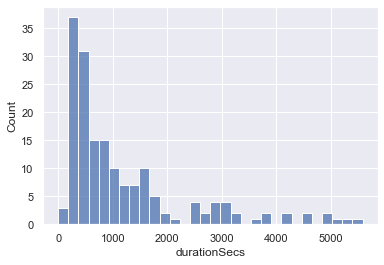

In [25]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)
plt.show()

#### Wordcloud for words in title

In [26]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

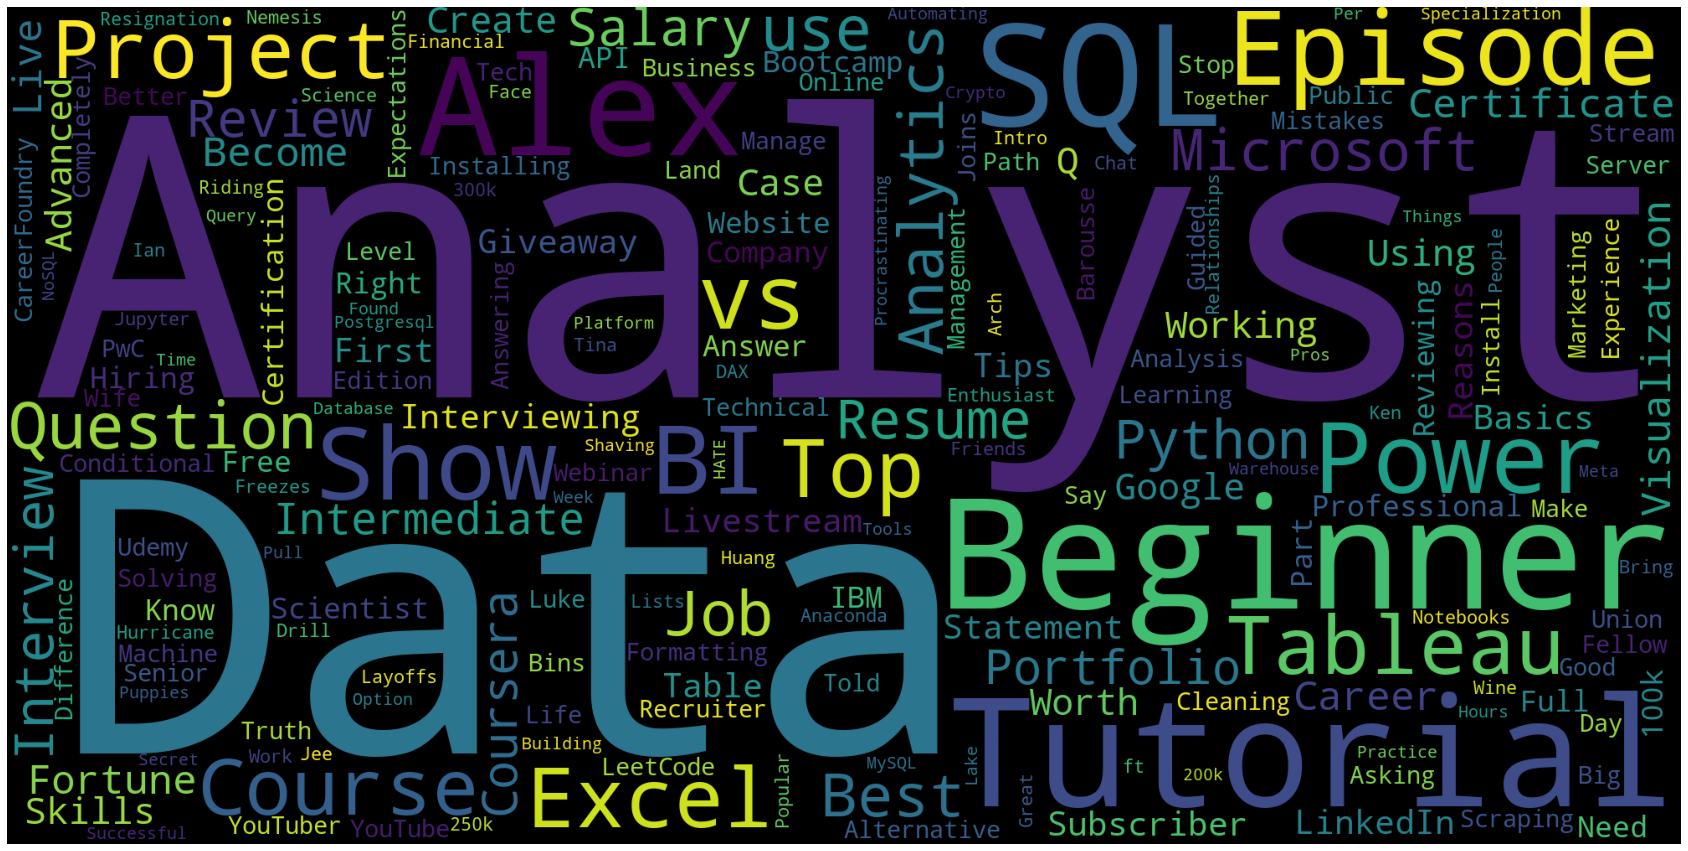

In [27]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Which day in the week are most videos uploaded?

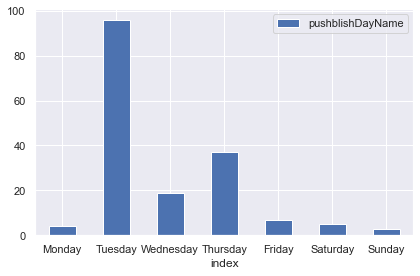

In [28]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)
plt.tight_layout()